<a href="https://colab.research.google.com/github/Fordreign/my_works/blob/main/Testovoe_Pepsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт инструментов

In [96]:
!pip install pyxlsb

In [97]:
import pandas as pd
import numpy as np
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Задача №1

Расчитать модель для прогноза с учетом:

1. цены на полке, скидки, количества торговых точек
2. цены на полке,  количества торговых точек
3. цены на полке

выбрать наилучшую модель

## Подготовка и исследование данных

In [98]:
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/DATA/pepsi_test.xlsb')

In [99]:
df.head(3)

,Дата начала отгрузок с наших складов под промо,Дата старта промо на полке,Дата окончания промо на полке,"Продолжительность промо на полке, дни",CU ID,Наименование CU,Промо поддержка,"Скидка на полке, %","Цена на полке, руб","Отгруженный объем, тонн","Кол-во торговых точек, участвующих в промо",Продажи на 1 торговую точку
0,2020-09-17,2020-09-22,2020-09-28,7,304505,Молоко пастеризованное-Домик в деревне-1000-3....,Снижение цены,0.20,59.99,494.97,2 823,0.18
1,2020-08-20,2020-08-25,2020-08-31,7,304505,Молоко пастеризованное-Домик в деревне-1000-3....,Снижение цены,0.20,59.99,526.38,2 816,0.19
2,2020-07-23,2020-07-28,2020-08-03,7,304505,Молоко пастеризованное-Домик в деревне-1000-3....,Снижение цены,0.29,59.99,495.83,2 798,0.18


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Дата начала отгрузок с наших складов под промо  42 non-null     datetime64[ns]
 1   Дата старта промо на полке                      42 non-null     datetime64[ns]
 2   Дата окончания промо на полке                   42 non-null     datetime64[ns]
 3   Продолжительность промо на полке, дни           42 non-null     int64         
 4   CU ID                                           42 non-null     int64         
 5   Наименование CU                                 42 non-null     object        
 6   Промо поддержка                                 42 non-null     object        
 7   Скидка на полке, %                              42 non-null     float64       
 8   Цена на полке, руб                              42 n

In [101]:
# Удалим лишние колонки
df.drop(['Наименование CU', 'Промо поддержка', 'CU ID', 'Продолжительность промо на полке, дни'], axis=1, inplace=True)

In [102]:
df.rename(columns={
    'Дата начала отгрузок с наших складов под промо': 'start',
    'Дата старта промо на полке': 'start_polka',
    'Дата окончания промо на полке': 'end_polka',
    'Скидка на полке, %': 'discount',
    'Цена на полке, руб': 'price',
    'Отгруженный объем, тонн': 'volume',
    'Кол-во торговых точек, участвующих в промо': 'count_shops',
    'Продажи на 1 торговую точку': 'sales_per_shop'
}, inplace=True)

In [103]:
df['count_shops'] = df['count_shops'].str.replace(' ', '').astype(int)

In [104]:
df.describe()

,discount,price,volume,count_shops,sales_per_shop
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.205714,62.455476,519.070952,2632.095238,0.198095
std,0.029808,3.777147,61.867185,118.341756,0.028132
min,0.150000,54.990000,393.390000,2390.000000,0.150000
25%,0.185000,59.990000,475.210000,2568.500000,0.180000
50%,0.210000,59.990000,511.675000,2627.500000,0.195000
75%,0.227500,64.990000,550.937500,2725.500000,0.217500
max,0.290000,69.990000,661.140000,2823.000000,0.270000


In [105]:
df.sample()

,start,start_polka,end_polka,discount,price,volume,count_shops,sales_per_shop
4,2020-06-04,2020-06-09,2020-06-15,0.25,64.99,408.94,2784,0.15


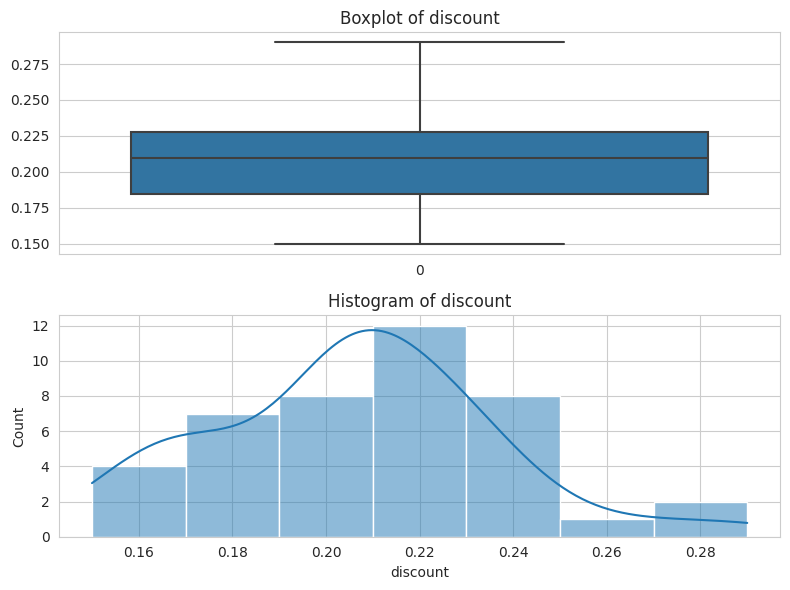

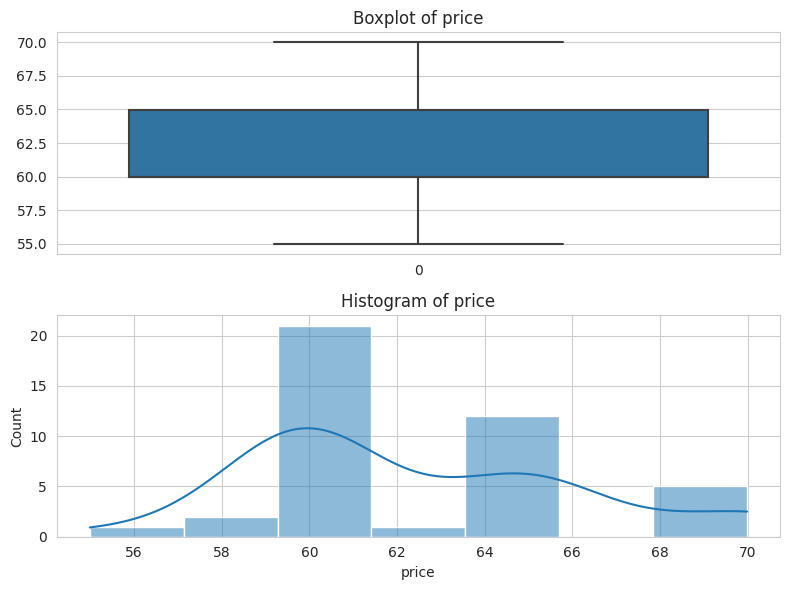

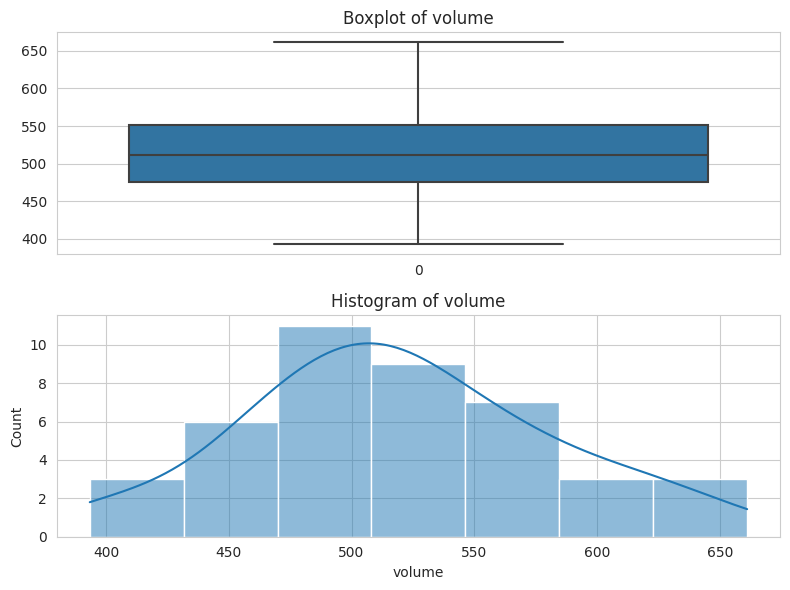

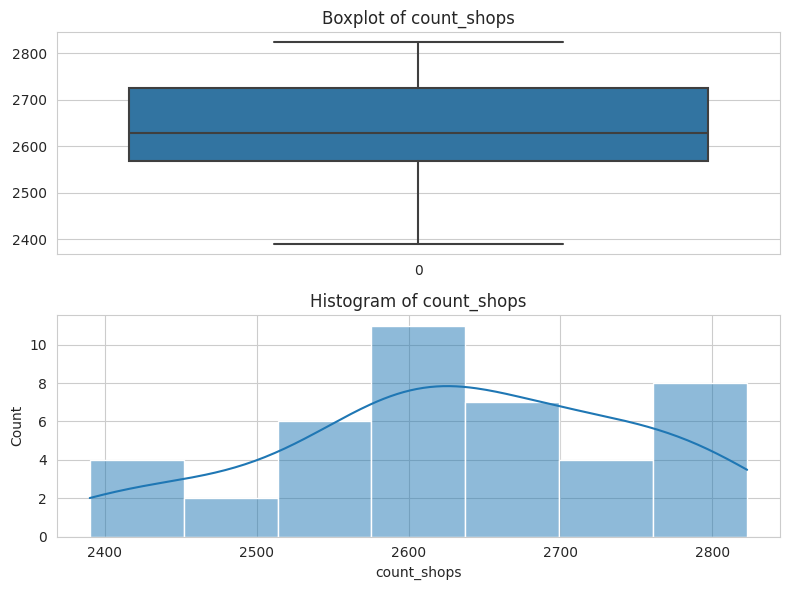

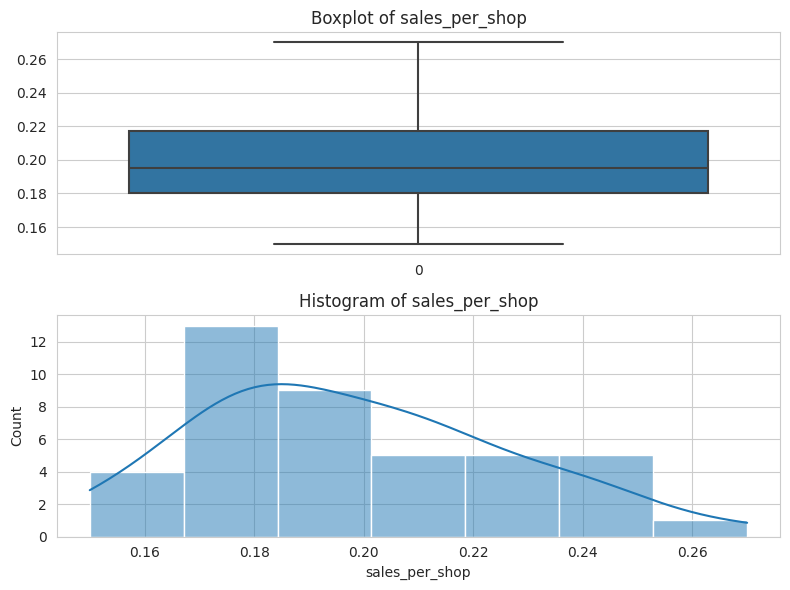

In [106]:
# Построение графиков для каждой колонки
columns = ['discount', 'price', 'volume', 'count_shops', 'sales_per_shop']

sns.set_style('whitegrid')

for column in columns:

    fig, axes = plt.subplots(nrows=2, figsize=(8, 6))

    # График boxplot
    sns.boxplot(data=df[column], ax=axes[0])
    axes[0].set_title(f'Boxplot of {column}')

    # График hist
    sns.histplot(data=df[column], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

Целевая метрика "Продажи на магазин" распределена неравномерна

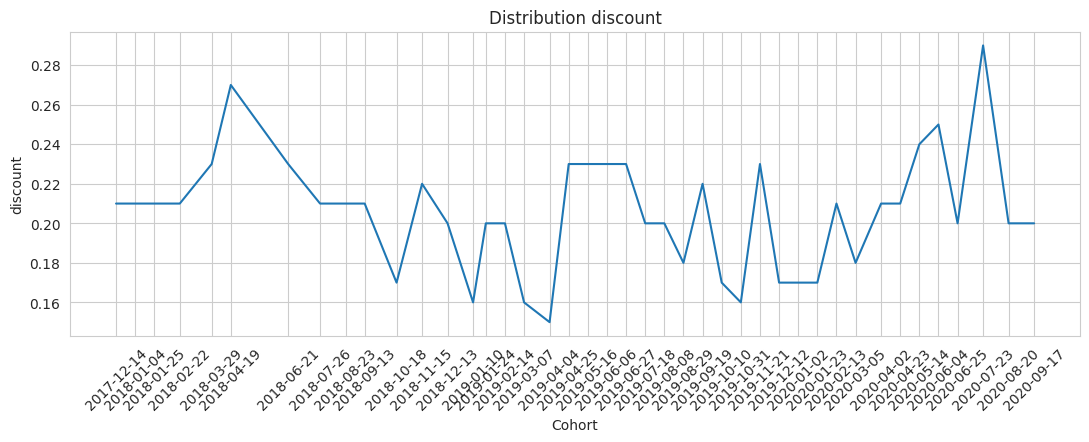

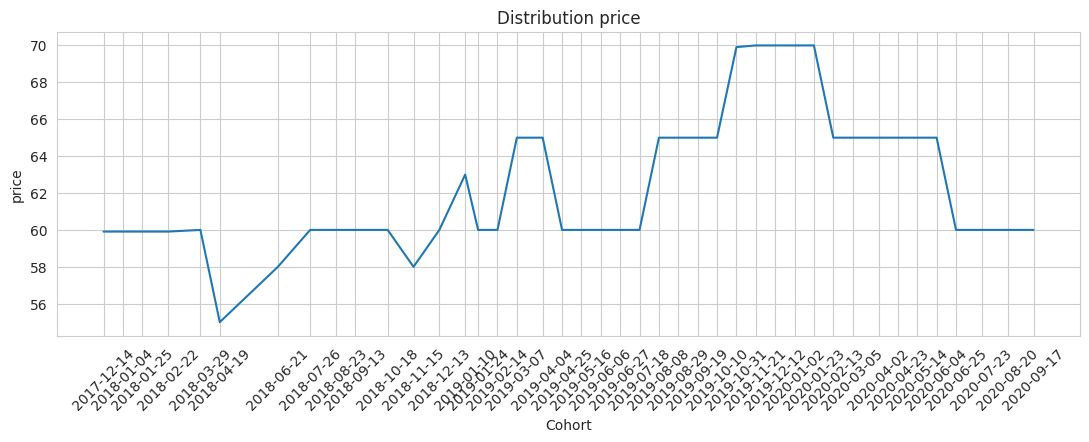

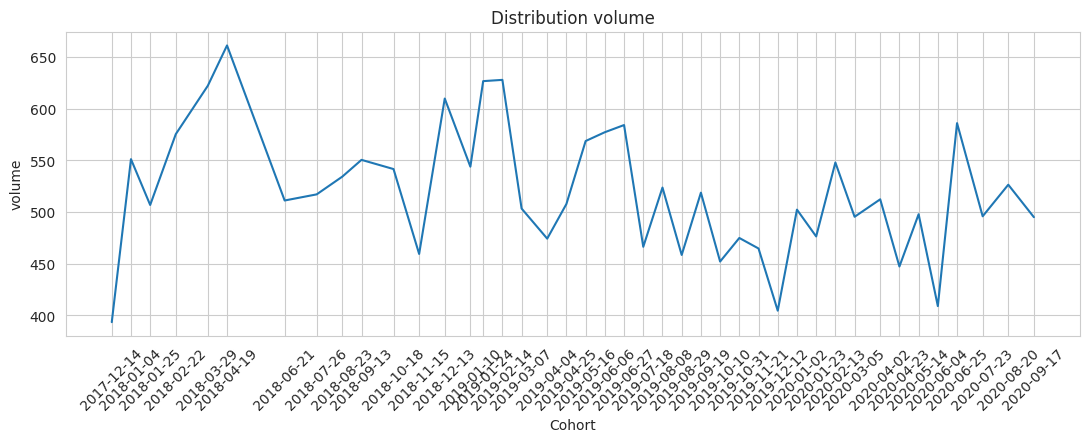

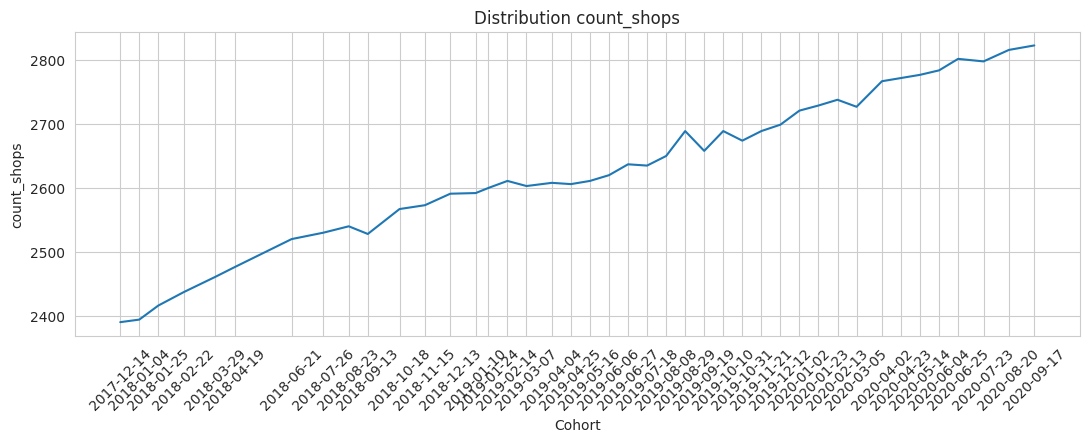

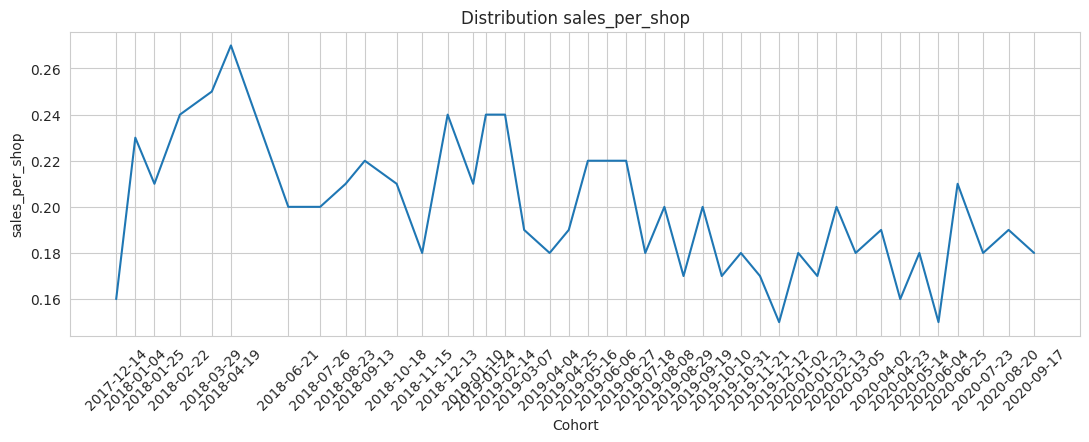

In [107]:
# Графики распределения в разрезе когорт 'start'
for column in columns:
    fig, ax = plt.subplots(figsize=(11, 4))
    sns.lineplot(y=df[column], x=df['start'], ax=ax)
    ax.set_title(f'Distribution {column}')
    ax.set_xlabel('Cohort')
    ax.set_ylabel(column)
    plt.tight_layout()
    ax.set_xticks(df['start'])
    plt.xticks(rotation=45)
    plt.show()


Наблюдения:

'count_shops' положительный тренд

У целевой метрики прослеживается отрицательный тренд с цикличным характером.

In [108]:
df.start.diff()

0         NaT
1    -28 days
2    -28 days
3    -28 days
4    -21 days
5    -21 days
6    -21 days
7    -21 days
8    -28 days
9    -21 days
10   -21 days
11   -21 days
12   -21 days
13   -21 days
14   -21 days
15   -21 days
16   -21 days
17   -21 days
18   -21 days
19   -21 days
20   -21 days
21   -21 days
22   -21 days
23   -21 days
24   -21 days
25   -28 days
26   -21 days
27   -21 days
28   -14 days
29   -28 days
30   -28 days
31   -28 days
32   -35 days
33   -21 days
34   -28 days
35   -35 days
36   -63 days
37   -21 days
38   -35 days
39   -28 days
40   -21 days
41   -21 days
Name: start, dtype: timedelta64[ns]

In [109]:
df.start.diff().describe()

count                              41
mean     -25 days +09:57:04.390243903
std         7 days 16:30:06.317638009
min                -63 days +00:00:00
25%                -28 days +00:00:00
50%                -21 days +00:00:00
75%                -21 days +00:00:00
max                -14 days +00:00:00
Name: start, dtype: object

Данные не равномерно распределены по времени.
Со средней периодичностью  в 25 дней.

In [110]:
# Перерасчет sales_per_shop
df['sales_per_shop'] = (df['volume']/df['count_shops']).round(3)
# Отсортируем по дате
df.sort_values(by='start', inplace=True, ascending=True)

In [111]:
df.set_index('start',inplace=True)

In [112]:
df.head(3)

,start_polka,end_polka,discount,price,volume,count_shops,sales_per_shop
start,,,,,,,
2017-12-14,2017-12-19,2017-12-25,0.21,59.9,393.39,2390,0.165
2018-01-04,2018-01-09,2018-01-15,0.21,59.9,551.11,2394,0.230
2018-01-25,2018-01-30,2018-02-05,0.21,59.9,506.77,2416,0.210


## Linear regression + XGBRegressor

###  1.цены на полке, скидки, количества торговых точек
Расчитать модель для прогноза с учетом

В качестве решения задачи возьмем пример гибридной модели, которая сочетает линейную регрессию для прогнозирования тренда и XGBoost для прогнозирования остатков после удаления тренда.

In [113]:
# Создание матрицы факторов и вектора зависимой переменной
X = df[['price', 'discount', 'count_shops']]
y = df['volume']

In [114]:
# Деление данных на обучающую и проверочную выборки
# В качестве test выборки возмем последние 8 строк (~8месяцев)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [115]:
X_test.sample()

,price,discount,count_shops
start,,,
2020-05-14,64.99,0.24,2777


Модель и обучение

In [116]:
# Линейная обучается и находит тренд, XGB находит цикл\сезон и учится на остатках
class LinXGB(BaseEstimator):
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2

    def fit(self, X, y):
        self.model_1.fit(X, y)
        y_pred_1 = self.model_1.predict(X)
        self.model_2.fit(X, y - y_pred_1)

    def predict(self, X):
        y_pred_1 = self.model_1.predict(X)
        y_pred_2 = self.model_2.predict(X)
        y_pred = y_pred_1 + y_pred_2
        return y_pred

In [117]:
model_1 = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_1.fit(X_train, y_train)

Оценка модели

In [118]:
# Предсказание
y_pred = model_1.predict(X_test)

# RMSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 10347.86319754703
RMSE: 101.72444739366752
MAPE: 19.121655482854443


In [119]:
results_df = pd.DataFrame( columns=["Model", "MSE", "RMSE", "MAPE"])
results_df = results_df.append({"Model": 'model_1', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

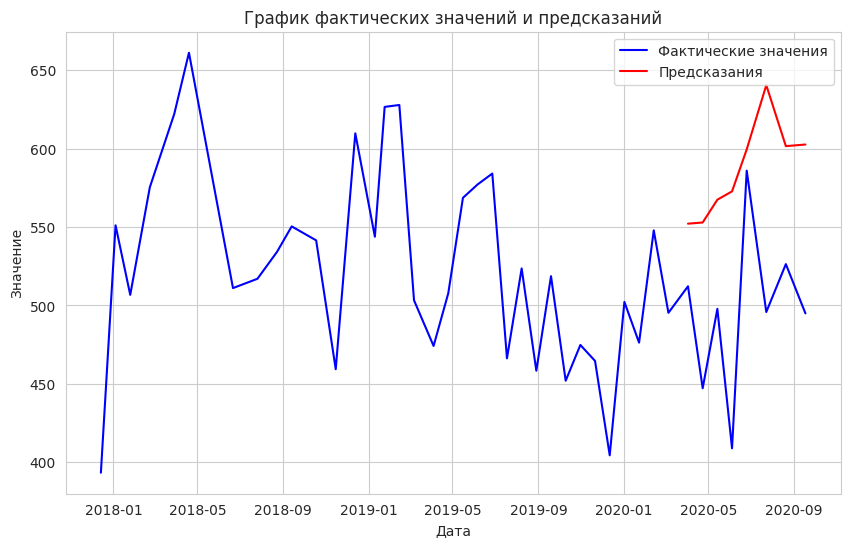

In [120]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

Как видно по графику  модель не может реагировать на резкие перепады. Добавление лагов в качестве признаков может помочь модели учитывать предыдущие значения и лучше реагировать на резкие перепады. Чтобы определить наличие значимых лагов следует построить графики автокорреляции.

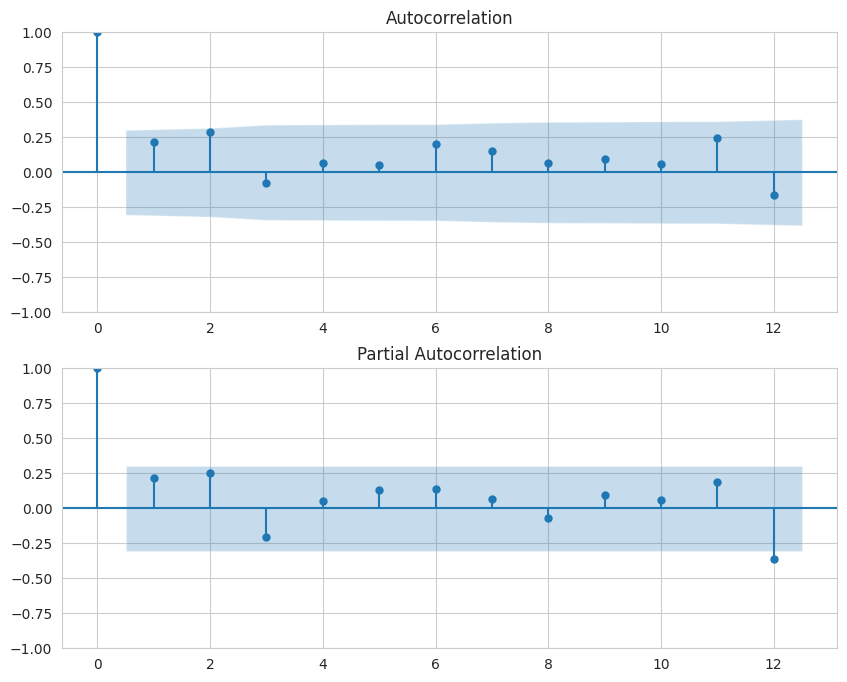

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['volume'], lags=12, ax=ax1)
plot_pacf(df['volume'], lags=12, ax=ax2)
plt.show()

По графика выше, у нас не нашлось лагов, которые бы привнесли доп. информацию для нашей модели.

Но для **эксперимента** возмем лаг равный 1 для всех данных

Эксперимент 2

In [122]:
# Добавим лаги целевой и X к данным
X_lagged = X.shift(1).dropna()
y_lagged = y.shift(1).dropna()

# Переименуем колонки
X_lagged.columns = [f'lag_{col}' for col in X.columns]
y_lagged.columns = ['lag_y']

#  Обьеденяем
X = pd.concat([X, X_lagged], axis=1).fillna(X.mean())
X = pd.concat([X, y_lagged], axis=1).fillna(y.mean())

In [123]:
X.sample()

,price,discount,count_shops,lag_price,lag_discount,lag_count_shops,volume
start,,,,,,,
2018-12-13,59.99,0.2,2591,57.99,0.22,2573.0,459.38


In [124]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [125]:
model_1_lag = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_1_lag.fit(X_train, y_train)
# Предсказание
y_pred = model_1_lag.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 3871.965731441628
RMSE: 62.2251213855114
MAPE: 10.833375657235047


In [126]:
results_df = results_df.append({"Model": 'model_1_lag', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

Как видно метрики потерь снизились, что дает нам положительный сигнал. Давайте же взглянем на прогнозы.

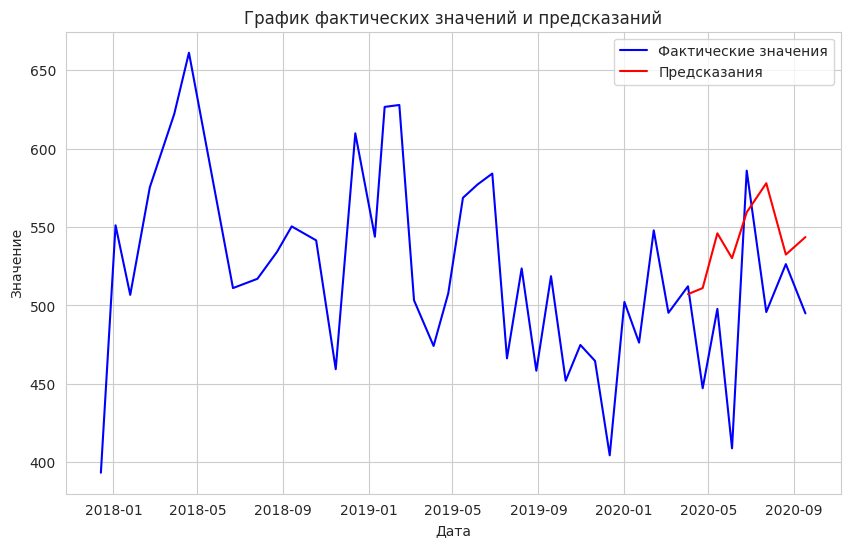

In [127]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

### 2.цены на полке, количества торговых точек


In [128]:
# Создание матрицы факторов и вектора зависимой переменной
X = df[['price', 'count_shops']]
y = df['volume']

In [129]:
# Деление данных на обучающую и проверочную выборки
# В качестве test выборки возмем последние 8 строк (~8месяцев)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [130]:
X_test.sample()

,price,count_shops
start,,
2020-06-04,64.99,2784


In [131]:
model_2 = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_2.fit(X_train, y_train)

In [132]:
# Предсказание
y_pred = model_2.predict(X_test)

# RMSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 9441.24214384538
RMSE: 97.16605448326787
MAPE: 18.674320225612167


In [133]:
results_df = results_df.append({"Model": 'model_2', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

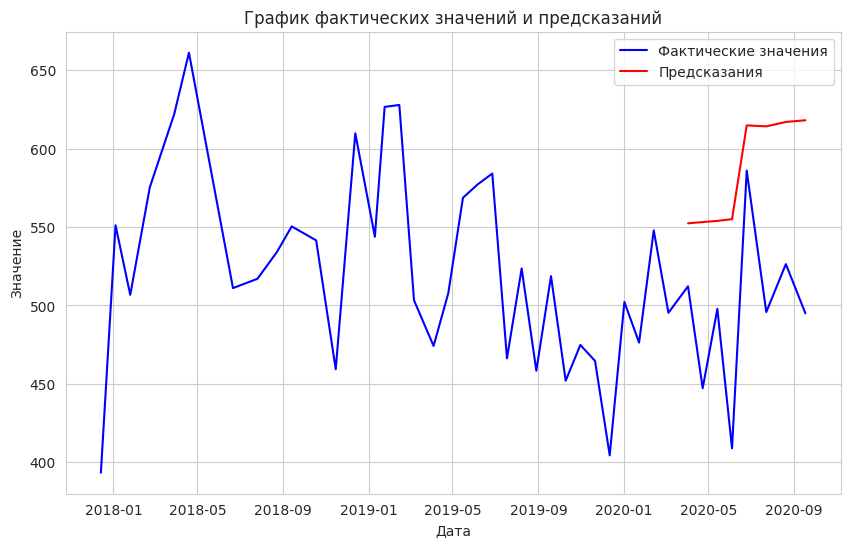

In [134]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

**Эксперимент 2**

In [135]:
# Добавим лаги целевой и X к данным
X_lagged = X.shift(1).dropna()
y_lagged = y.shift(1).dropna()

# Переименуем колонки
X_lagged.columns = [f'lag_{col}' for col in X.columns]
y_lagged.columns = ['lag_y']

#  Обьеденяем
X = pd.concat([X, X_lagged], axis=1).fillna(X.mean())
X = pd.concat([X, y_lagged], axis=1).fillna(y.mean())

In [136]:
X.sample()

,price,count_shops,lag_price,lag_count_shops,volume
start,,,,,
2019-08-08,64.99,2650,59.99,2635.0,466.3


In [137]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [138]:
model_2_lag = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_2_lag.fit(X_train, y_train)
# Предсказание
y_pred = model_2_lag.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2054.800323750898
RMSE: 45.32990540196282
MAPE: 7.666611196022155


In [139]:
results_df = results_df.append({"Model": 'model_2_lag', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

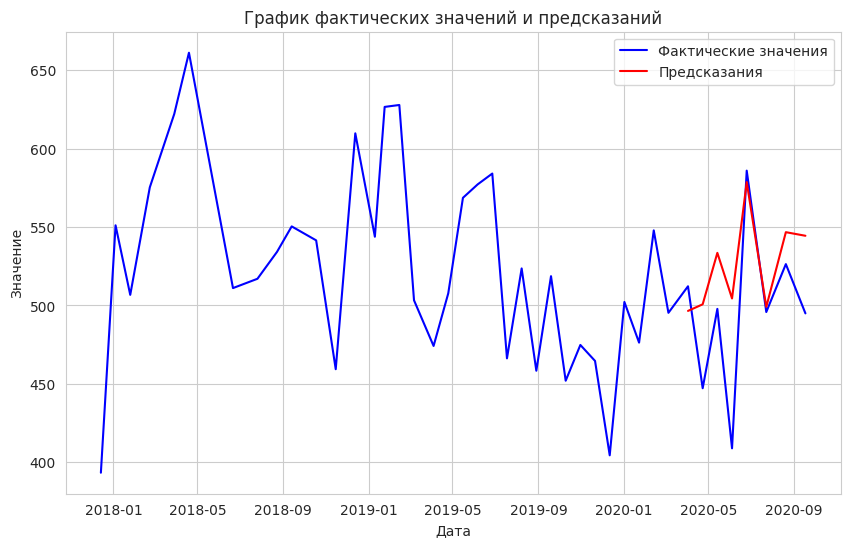

In [140]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

### 3.цены на полке

In [141]:
# Создание матрицы факторов и вектора зависимой переменной
X = df['price']
y = df['volume']

In [142]:
# Деление данных на обучающую и проверочную выборки
# В качестве test выборки возмем последние 8 строк (~8месяцев)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [143]:
X_train.sample()

start
2018-06-21    57.99
Name: price, dtype: float64

In [144]:
model_3 = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_3.fit(np.array(X_train).reshape(-1, 1)
, y_train)
# Предсказание
y_pred = model_3.predict(np.array(X_test).reshape(-1, 1)
)

# RMSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2716.3905877788857
RMSE: 52.119004094273386
MAPE: 9.302072778663764


In [145]:
results_df = results_df.append({"Model": 'model_3', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

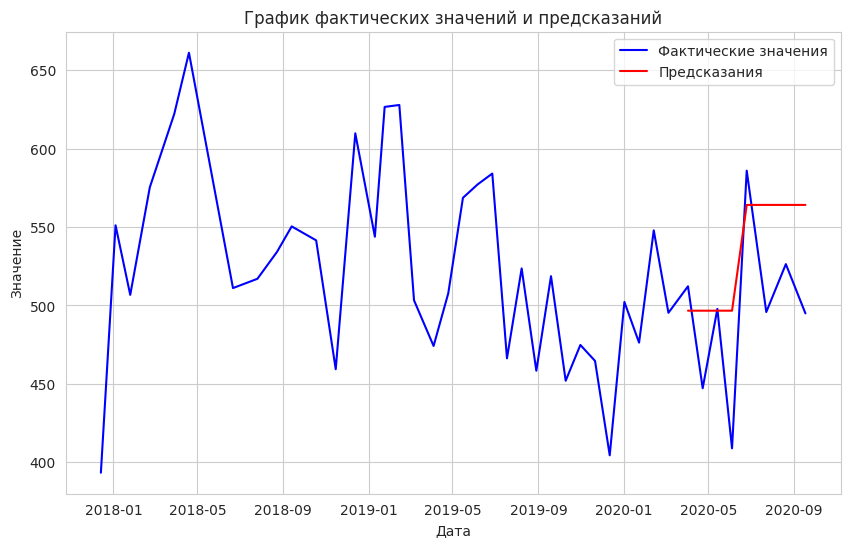

In [146]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

Эксперимент 2

In [147]:
# Добавим лаги целевой и X к данным
X_lagged = X.shift(1).dropna()
y_lagged = y.shift(1).dropna()

# Переименуем колонки
X_lagged.name = 'lag_price'
y_lagged.name = 'lag_y'

#  Обьеденяем
X = pd.concat([X, X_lagged], axis=1).fillna(X.mean())
X = pd.concat([X, y_lagged], axis=1).fillna(y.mean())

In [148]:
X.sample()

,price,lag_price,lag_y
start,,,
2019-01-10,62.99,59.99,609.75


In [149]:
# Деление данных на обучающую и проверочную выборки
# В качестве test выборки возмем последние 8 строк (~8месяцев)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [150]:
model_3_lag = LinXGB(LinearRegression(), XGBRegressor(random_state=69))
# Обучение
model_3_lag.fit(X_train, y_train)
# Предсказание
y_pred = model_3_lag.predict(X_test)

# RMSE
mse = mean_squared_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2611.004781465711
RMSE: 51.097991951403635
MAPE: 8.379332027269228


In [151]:
results_df = results_df.append({"Model": 'model_3_lag', "MSE": mse, "RMSE": np.sqrt(mse), "MAPE": mape}, ignore_index=True)

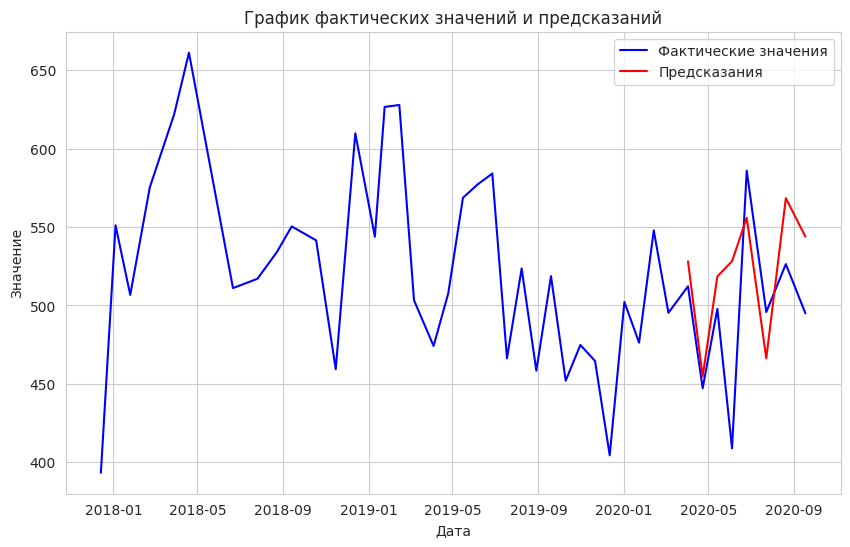

In [152]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_pred, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

## ExponentialSmoothing + LSTM

Попробуем другую комбинацию алгоритмов Экспоненциально сглаживание будет находить тренд, а рекурентная сеть LSTM будет пытасться учиться на остатках для выявления цикл\сезонов.

Проведем также два эксперимента попосмотрим какие результаты выдает будущая модель с обычными данными и с данными обогащенными лагами признаков и целевой переменной.




In [153]:
# Создание матрицы факторов и вектора зависимой переменной
X = df[['price', 'discount', 'count_shops']]
y = df['volume']
# Деление данных на обучающую и проверочную выборки
# В качестве test выборки возмем последние 8 строк (~8месяцев)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=8, shuffle=False)

In [154]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34, 3) (8, 3) (34,) (8,)


Модель

Для начала иницилизурем ExponentialSmoothing, далее с помощью сетки найдем наилучшие гиперпараметры и сделаем предикты , для входа LSTM

In [155]:
params = {
    'trend': ['add', 'mul'],
    'smoothing_level': [0.2, 0.5, 0.8],
}

# Инициализация переменных для лучших параметров и значения метрики
best_params = None
best_score = float('inf')

# Перебор всех комбинаций параметров
for param_values in itertools.product(*params.values()):
    # Получение текущих значений параметров
    trend, smoothing_level = param_values

    exp_model = ExponentialSmoothing(y_train, trend=trend)

    # Обучение
    exp_model_fit = exp_model.fit(smoothing_level=smoothing_level)
    # Прогноз
    y_pred = exp_model_fit.forecast(len(y_test))

    #  MSE
    mse = mean_squared_error(y_test, y_pred)

    # проверка является ли текущий набор параметров лучшим
    if mse < best_score:
        best_score = mse
        best_params = param_values

# Вывод
print("Best Parameters: ", best_params)
print("MSE: ", best_score)

Best Parameters:  ('add', 0.5)
MSE:  2505.1137919083894


Создадим входные признаки для LSTM

*   Обучение на остатках y_train
*   Тест и валидация на остатках y_test



In [156]:
# y_train остатки
exp_model = ExponentialSmoothing(y_train, trend='add')
exp_model_fit = exp_model.fit(smoothing_level=0.5)

y_train_pred = exp_model_fit.predict(start=y_train.index[0], end=y_train.index[-1])
y_train_res = y_train - y_train_pred

# y_test остатки
exp_model = ExponentialSmoothing(y_test, trend='add')
exp_model_fit = exp_model.fit(smoothing_level=0.5)

y_test_pred = exp_model_fit.forecast(len(y_test))
y_test_pred.index = y_test.index
y_test_res = y_test - y_test_pred

In [157]:
X_train.shape, y_train_res.shape, X_test.shape, y_test_res.shape

((34, 3), (34,), (8, 3), (8,))

In [158]:
# Создадим Тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_res.values, dtype=torch.float32)

# Нет даталоадера поэтому бачи = 1
X_train_tensor = X_train_tensor.unsqueeze(0)
X_test_tensor = X_test_tensor.unsqueeze(0)


print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([1, 34, 3])
torch.Size([34])
torch.Size([1, 8, 3])
torch.Size([8])


LSTM

In [159]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=4)
        self.linear1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(1, 0, 2)
        output = self.linear1(lstm_out)
        output = output.squeeze(2)
        return output

In [160]:
model = LSTMModel(input_size=3, hidden_size=24, output_size=1)
# зададим МSE loss и оптимизато Адам
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Обучение и валидация

In [161]:
num_epochs = 1000
for epoch in range(num_epochs):
    # Прямой проход
    outputs = model(X_train_tensor)
    # print(outputs.squeeze().shape)
    loss = loss_fn(outputs.squeeze(), y_train_tensor)

    # Обратный
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Промежуточные результаты
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 4027.1631
Epoch [200/1000], Loss: 4027.1631
Epoch [300/1000], Loss: 4027.1631
Epoch [400/1000], Loss: 4027.1631
Epoch [500/1000], Loss: 4027.1631
Epoch [600/1000], Loss: 4027.1631
Epoch [700/1000], Loss: 4027.1631
Epoch [800/1000], Loss: 4027.1631
Epoch [900/1000], Loss: 4027.1631
Epoch [1000/1000], Loss: 4027.1631


P.S. Я изменял гипермапарметры и архитектуру сети , но модель попадает сразу в седловую точку и не может выйти за предела частного оптимума.

Прогноз LSTM и получение предсказание от ансамбля моделей

In [162]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = loss_fn(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 2998.9963


In [163]:
test_outputs = model(X_test_tensor)
test_outputs.shape

torch.Size([8, 1])

In [164]:
test_outputs.squeeze().detach().numpy()

array([0.00136437, 0.00136437, 0.00136437, 0.00136437, 0.00136437,
       0.00136437, 0.00136437, 0.00136437], dtype=float32)

In [165]:
y_test_pred_ensemble = y_test_pred + test_outputs.squeeze().detach().numpy()
y_test_pred_ensemble

start
2020-04-02    511.920656
2020-04-23    515.074578
2020-05-14    518.228500
2020-06-04    521.382422
2020-06-25    524.536345
2020-07-23    527.690267
2020-08-20    530.844189
2020-09-17    533.998111
dtype: float64

Взглянем на график прогноза

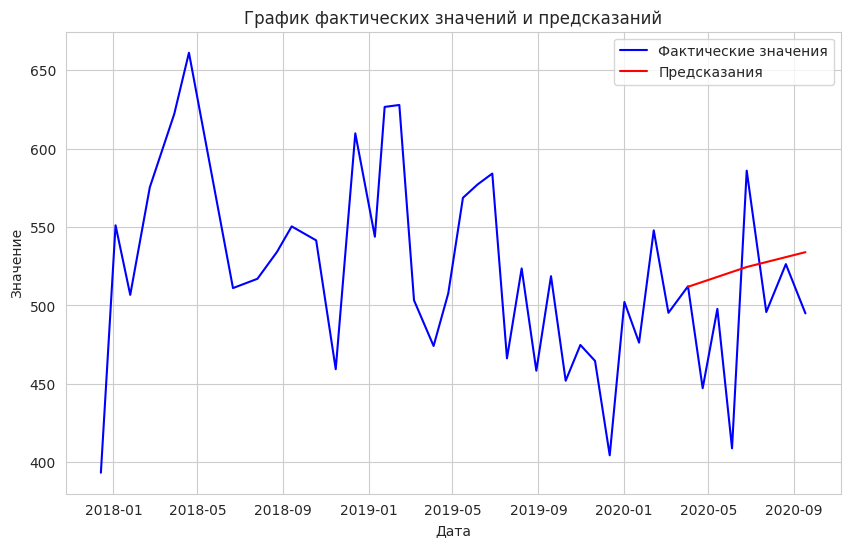

In [166]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(X_test.index, y_test_pred_ensemble, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

Недостаток данных и сложность модели не дает ей лучше находить зависимости, в следствие чего мы получили только экспоненциальное сглажевание, как главый предиктор.

P.S. Данный цикл анализа я оставил в качестве демонстрации моих навыков, и в итоговой таблице моделей не указывал этот ансамбль.

## Итог

In [167]:
results_df

,Model,MSE,RMSE,MAPE
0,model_1,10347.863198,101.724447,19.121655
1,model_1_lag,3871.965731,62.225121,10.833376
2,model_2,9441.242144,97.166054,18.674320
3,model_2_lag,2054.800324,45.329905,7.666611
4,model_3,2716.390588,52.119004,9.302073
5,model_3_lag,2611.004781,51.097992,8.379332


Как видно из таблицы - модель(model_2_lag), которая делала прогноз с учетом цены на полке и кол-ва торговых точек показала наилучшие показатели по метрикам потерь и визуально по графику видно, что она продемонстрировала хорошие результаты в выявлении трендов и изменений.

Для достижения луших показател можно было стандартизировать данные и попытаться еще подобрать лучшие фичи для наших моделей , сделать боллее глубойкий анализ корреляций и автокорреляци, а также разложение тренда, цикла и сезонности с использованием ряда Фурье.

Также можно было подойти с другой стороны, попыться улучшить модели , провести кроссвалидацию и гридсерч для поиска оптимальных гипермпараметров , добавить регуляризацию и т.д.

# Задача №2

Построить прогноз на 3-5 недель, основываясь на исторических данных:
1. используя модель Хольта-Винтерса
2. используя модель ARIMA
3. Любая другая модель

## Подготовка и исследование данных

In [168]:
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/DATA/pepsi_test.xlsb', sheet_name='Лист2')

In [169]:
df.head()

,Год,Неделя,"Отгруженный на клиента объем, тонн"
0,2018,1,"5 115,92"
1,2018,2,"7 274,49"
2,2018,3,"5 768,75"
3,2018,4,"6 995,50"
4,2018,5,"6 369,46"


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Год                                 164 non-null    int64 
 1   Неделя                              164 non-null    int64 
 2   Отгруженный на клиента объем, тонн  164 non-null    object
dtypes: int64(2), object(1)
memory usage: 4.0+ KB


In [171]:
df = df.rename(columns={
    'Год': 'year',
    'Неделя': 'week',
    'Отгруженный на клиента объем, тонн': 'volume'
})

In [172]:
# исправим тип данных
df.volume = df.volume.str.replace(' ', '')
df.volume = df.volume.str.replace(',', '.').astype(float)

In [173]:
df.head()

,year,week,volume
0,2018,1,5115.92
1,2018,2,7274.49
2,2018,3,5768.75
3,2018,4,6995.50
4,2018,5,6369.46


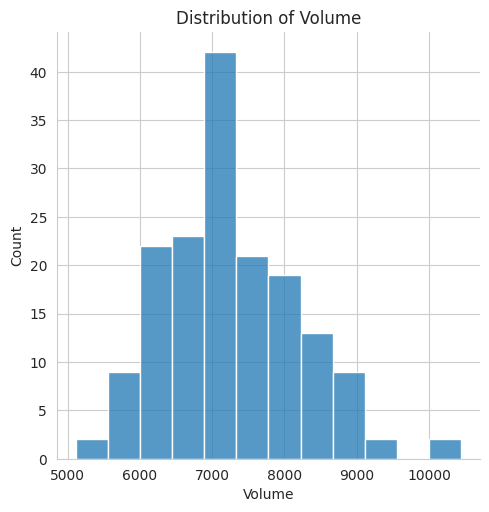

In [174]:
sns.displot(df['volume'])
plt.xlabel('Volume')
plt.ylabel('Count')
plt.title('Distribution of Volume')
plt.show()

In [175]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-W' + df['week'].astype(str) + '-1', format='%Y-W%W-%w')
df.drop(['year', 'week'], axis=1, inplace=True)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [176]:
df.head()

,volume
date,
2018-01-01,5115.92
2018-01-08,7274.49
2018-01-15,5768.75
2018-01-22,6995.50
2018-01-29,6369.46


In [177]:
# Будем проводить прогноз на 5 недель,
# для этого в качестве тестовой выборки возмем последние 5 строк
train_data = df['volume'][:-5]
test_data = df['volume'][-5:]

## Хольт-Винтерс

Сперва подберем параметры модели Хольта-Винтерса для анализа тренда, сезонности и остатков


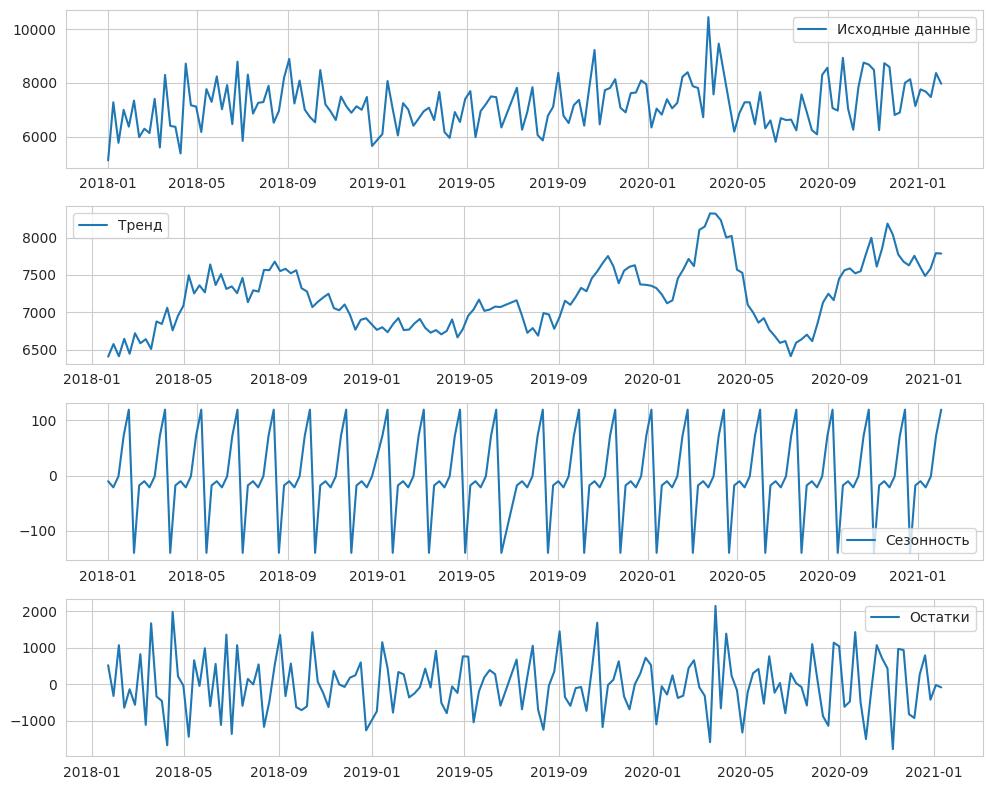

In [178]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(train_data, model='additive', period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализируем тренд, сезонность и остатки
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(train_data.index.values, train_data.values, label='Исходные данные')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Сезонность')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Явная сезонность с мултипликативным трендом

In [179]:
# Сетка
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [7,15,30],
    'use_boxcox': [True, False]
}

# Создаем список всех возможных комбинаций параметров
param_combinations = list(ParameterGrid(param_grid))
metric_scores = []

# Перебираем все комбинации параметров
for params in param_combinations:
    model = ExponentialSmoothing(train_data, trend=params['trend'], seasonal=params['seasonal'],
                                seasonal_periods=params['seasonal_periods'])
    fitted_model = model.fit()
    metric_scores.append(fitted_model.aic)

# Находим комбинацию параметров с наименьшим значением AIC
best_params = param_combinations[np.argmin(metric_scores)]

# Создаем и обучаем модель с лучшими параметрами
best_model = ExponentialSmoothing(train_data, trend=best_params['trend'], seasonal=best_params['seasonal'],
                                 seasonal_periods=best_params['seasonal_periods'], use_boxcox=best_params['use_boxcox'])
fitted_best_model = best_model.fit()

# результаты
print("Лучшие параметры модели: ", best_params)
print("AIC модели с лучшими параметрами: ", fitted_best_model.aic)

Лучшие параметры модели:  {'seasonal': 'add', 'seasonal_periods': 30, 'trend': 'add', 'use_boxcox': True}
AIC модели с лучшими параметрами:  2151.8113304956278


In [180]:
predict = fitted_best_model.forecast(5)

In [183]:
# MSE
mse = mean_squared_error(test_data, predict)

# MAPE
mape = np.mean(np.abs((test_data - predict) / test_data)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2616508.290795043
RMSE: 1617.562453445011
MAPE: nan


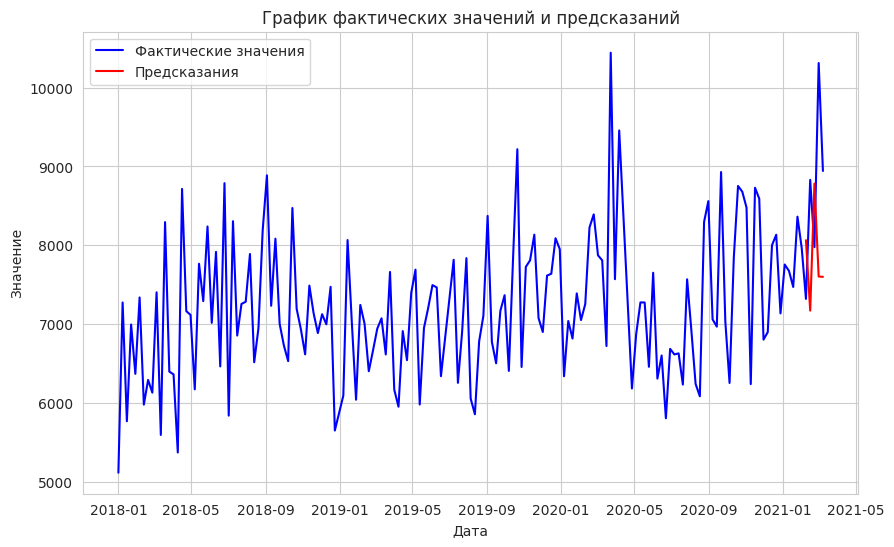

In [184]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(test_data.index, predict, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

Модель реаггирет с опазданием , возможно тут пристуствует автокорреляция.

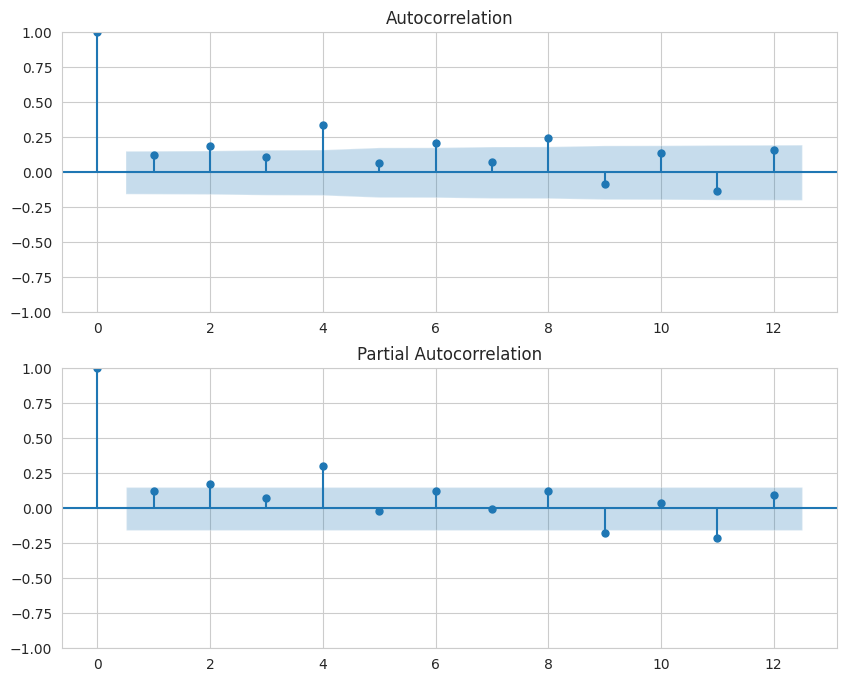

In [185]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['volume'], lags=12, ax=ax1)
plot_pacf(df['volume'], lags=12, ax=ax2)
plt.show()

В данном случае, значения на лагах 4, 9, 11 могут указывать на значимую автокорреляцию на этих лагах.

## ARIMA

Подберем гиперпараметры и сделаем прогноз с графиком

In [186]:
#  диапазон  значений для p, d и q
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)

# список всех  комбинаций гиперпараметров
parameters = list(itertools.product(p_range, d_range, q_range))

best_aic = float("inf")
best_params = None

# перебираем все комбинации гиперпараметров и выбираем лучшую модель по метрике AIC
for params in parameters:
    try:
        model = ARIMA(train_data, order=params)
        fitted_model = model.fit()
        aic = fitted_model.aic

        if aic < best_aic:
            best_aic = aic
            best_params = params
    except:
        continue

# ссздаем и обучаем ARIMA модель с лучшими гиперпараметрами
best_model = ARIMA(train_data, order=best_params)
fitted_best_model = best_model.fit()

In [187]:
predict = fitted_best_model.forecast(5)

In [188]:
# MSE
mse = mean_squared_error(test_data, predict)

# MAPE
mape = np.mean(np.abs((test_data - predict) / test_data)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2501024.8693329347
RMSE: 1581.4628890153997
MAPE: nan


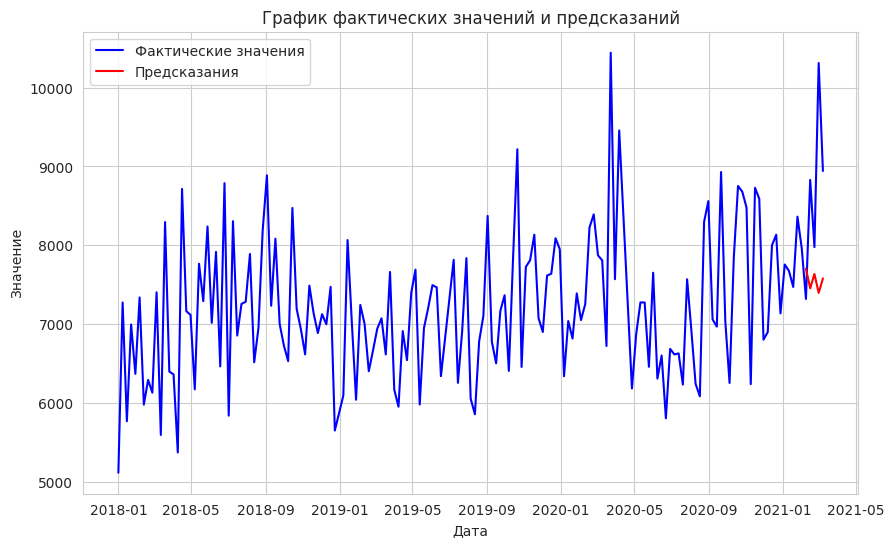

In [189]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(test_data.index, predict, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

## SARIMA

SARIMA лучше апроксимирует сезонные данные, поэтому мой выбор пал на эту модель.

In [190]:
# сетка значений
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
s_range = [4, 12]

# список всех возможных комбинаций гиперпараметров
parameters = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))

best_aic = float("inf")
best_params = None

# перебираем все комбинации гиперпараметров и выбираем лучшую модель по метрике AIC
for params in parameters:
    try:
        model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:], enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit()
        aic = fitted_model.aic

        if aic < best_aic:
            best_aic = aic
            best_params = params
    except:
        continue

# ссздаем и обучаем SARIMA модель с лучшими гиперпараметрами
best_model = SARIMAX(train_data, order=best_params[:3], seasonal_order=best_params[3:], enforce_stationarity=False, enforce_invertibility=False)
fitted_best_model = best_model.fit()


In [191]:
predict = fitted_best_model.forecast(5)

In [192]:
# MSE
mse = mean_squared_error(test_data, predict)

# MAPE
mape = np.mean(np.abs((test_data - predict) / test_data)) * 100

print("MSE:", mse)
print("RMSE:", np.sqrt(mse))
print("MAPE:", mape)

MSE: 2702629.8608819325
RMSE: 1643.9677189293993
MAPE: nan


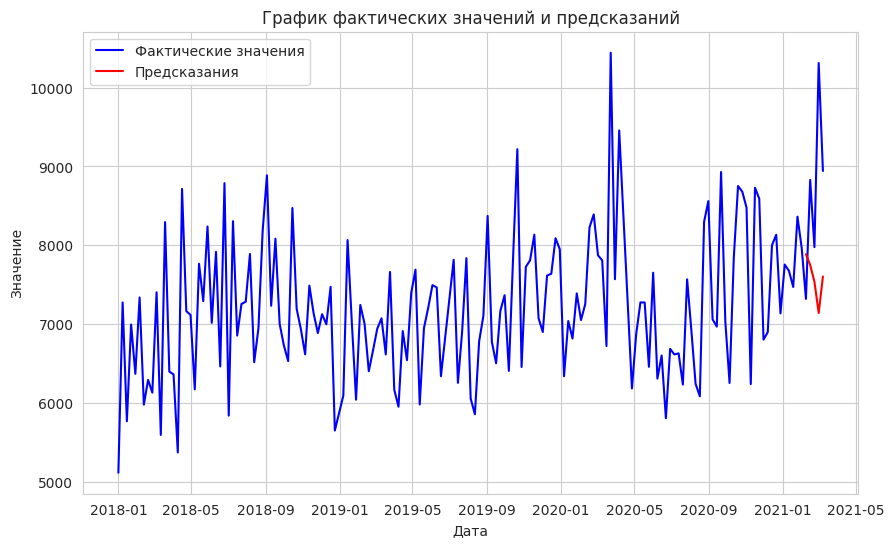

In [193]:
# график прогноза
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['volume'], color='blue', label='Фактические значения')
ax.plot(test_data.index, predict, color='red', label='Предсказания')
ax.set(xlabel='Дата', ylabel='Значение', title='График фактических значений и предсказаний')
ax.legend()
plt.show()

## Итог

Лучшей моделью по функции потерь оказалась ARIMA, но с визуальной стороны Экспоненцильное Сглажевание было более близким к фактическим значениям

# Вывод

В данной тетради решались две задачи временных рядов. Мы использовали как простые базовые статистические модели, так и сложные ансамбли классических алгоритмов машинного обучения с рекуррентными сетями.

Провели глубокий анализ данных, выявили паттерны и взаимосвязи, рассмотрели графики распределений и прогнозов, оценивали степень корреляции временных показателей. Оценивали качество моделей и пытались подобрать лучшие параметры для повышения точности результатов. Было проделано большое количество работы, но не все подходы и решения были использованы.

Для улучшения результатов мы могли бы провести нормализацию данных, удалить или исключить лишние данные. Также возможно провести более обширный анализ с использованием различных комбинаций для ансамблирования моделей, использовать кросс-валидацию для поиска оптимальных гиперпараметров и регуляризацию.

Моя главная цель была продемонстрировать  навыки, и я считаю, что она успешно выполнена.

Благодарю вас за внимание и интерес к работе!